
📊 RESULTADOS DEL BACKTEST (modelo cargado):
📈 Retorno Modelo ML     : 1.88%
💼 Retorno Buy & Hold    : 28.27%
🔢 Total señales de compra: 1297


C:\Users\pedro\AppData\Local\Temp\ipykernel_11388\2128692448.py:87: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\pedro\AppData\Local\Temp\ipykernel_11388\2128692448.py:87: UserWarning: Glyph 128188 (\N{BRIEFCASE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\pedro\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pedro\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128188 (\N{BRIEFCASE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


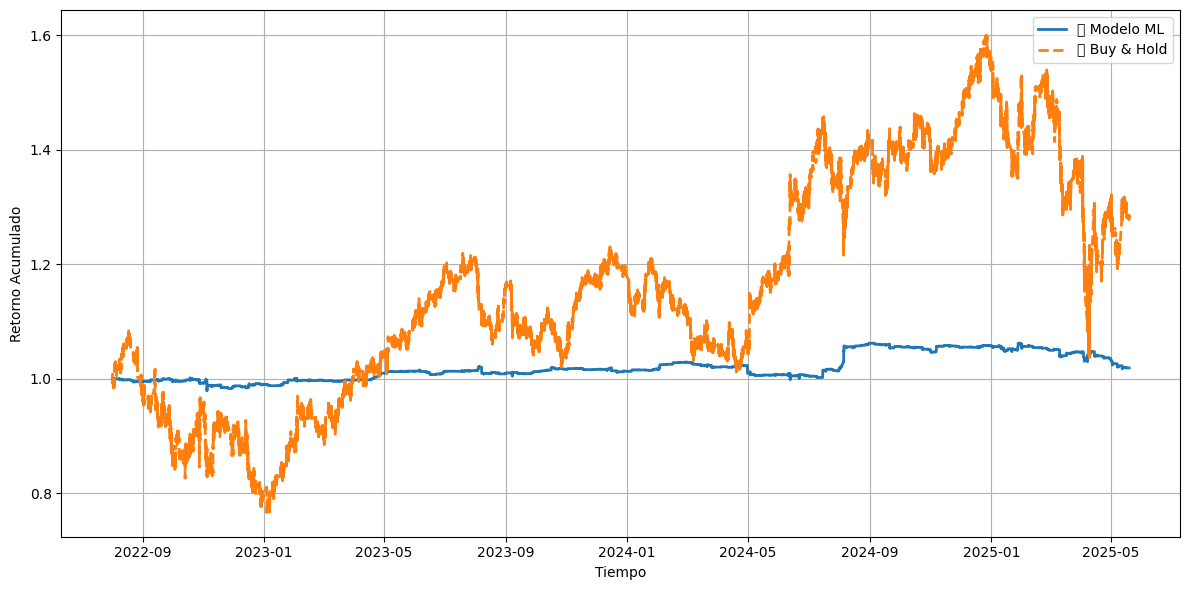

In [10]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# 📂 Rutas
CSV_PATH = './Processed Data2/AAPL.csv'  # Cambia por el ticker que quieras
MODELO_PATH = './Modelos Entrenados/modelo_logistica.pkl'
SCALER_PATH = './Modelos Entrenados/modelo_logistica_scaler.pkl'

# 🔢 Features que el modelo espera
FEATURES = ['close', 'volume', 'sma20', 'rsi20', 'bbhigh', 'bblow']

# 📥 Cargar CSV y parsear timestamp
df = pd.read_csv(CSV_PATH)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 🧠 Cargar modelo y scaler entrenados
modelo = joblib.load(MODELO_PATH)
scaler = joblib.load(SCALER_PATH)

# ✨ Preparar datos
X = df[FEATURES]
X_scaled = scaler.transform(X)

# 🔮 Generar señales con modelo entrenado
df['signal'] = modelo.predict(X_scaled)

# 💼 Simulación realista de portafolio
capital = 10000
shares = 0
last_price = 0
portfolio_value = []
transaction_cost = 0.02  # 2% sobre ganancia

for i in range(len(df)):
    precio_actual = df.loc[i, 'close']
    signal = df.loc[i, 'signal']

    # Comprar
    if signal == 1 and shares == 0:
        shares = capital / precio_actual
        capital = 0
        last_price = precio_actual

    # Vender
    elif signal == 0 and shares > 0:
        venta_bruta = shares * precio_actual
        ganancia = venta_bruta - (shares * last_price)
        comision = transaction_cost * ganancia if ganancia > 0 else 0
        capital = venta_bruta - comision
        shares = 0
        last_price = 0

    # Calcular valor total del portafolio
    valor_total = capital + (shares * precio_actual)
    portfolio_value.append(valor_total)

# Guardar columna de evolución del portafolio
df['portfolio_value'] = portfolio_value

# 📉 Simulación de estrategia del modelo
df['next_close'] = df['close'].shift(-1)
df['modelo_retorno'] = np.where(df['signal'] == 1, df['next_close'] / df['close'] - 1, 0)
df['modelo_acumulado'] = (1 + df['modelo_retorno']).cumprod()

# 💼 Estrategia Buy & Hold
df['buy_hold_acumulado'] = df['close'] / df['close'].iloc[0]

# 🧪 Métricas
final_modelo = df['modelo_acumulado'].iloc[-2]  # -2 por el shift
final_hold = df['buy_hold_acumulado'].iloc[-1]

print("\n📊 RESULTADOS DEL BACKTEST (modelo cargado):")
print(f"📈 Retorno Modelo ML     : {(final_modelo - 1) * 100:.2f}%")
print(f"💼 Retorno Buy & Hold    : {(final_hold - 1) * 100:.2f}%")
print(f"🔢 Total señales de compra: {df['signal'].sum()}")  

# 📈 Gráfico comparativo
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['modelo_acumulado'], label='📈 Modelo ML', linewidth=2)
plt.plot(df['timestamp'], df['buy_hold_acumulado'], label='💼 Buy & Hold', linestyle='--', linewidth=2)
plt.xlabel("Tiempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig('./Resultados Bactesting/grafico_backtest_modelo_cargado.png')
plt.show()
